<h1>Gating Experiments: FMO KNN</h1>

In [1]:
from immunova.data.project import Project
from immunova.data.mongo_setup import global_init
from immunova.flow.gating.actions import Template
from tqdm import tqdm_notebook, tqdm
from functools import partial
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
global_init()

In [2]:
peritonitis = Project.objects(project_id='Peritonitis').get()

<h2>Create some populations using the T Panel</h2>

In [3]:
peritonitis.list_fcs_experiments()

['PBMC_T', 'PDMC_T', 'PBMC_M', 'PDMC_M']

In [4]:
pdmc_t = peritonitis.load_experiment('PDMC_T')

In [5]:
t_template = Template(experiment=pdmc_t, sample_id='pd318-01_t')

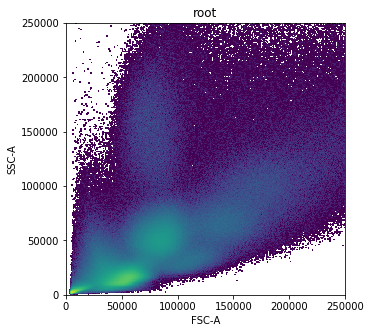

In [6]:
_ = t_template.plot_population('root', x='FSC-A', y='SSC-A')

<h3>Boundary gate</h3>

In [7]:
kwargs=dict(x_min=10000, x_max=125000, y_min=0, y_max=70000)
t_template.create_gate(gate_name='boundary_gate', children=['cells'], parent='root', x='FSC-A',
                      y='SSC-A', func='rect_gate', func_args=kwargs, gate_type='geom')

True

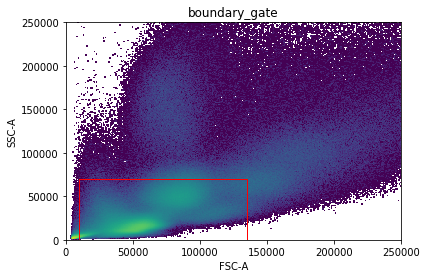

In [8]:
t_template.apply('boundary_gate')

<h3>Lymphocyte gate</h3>

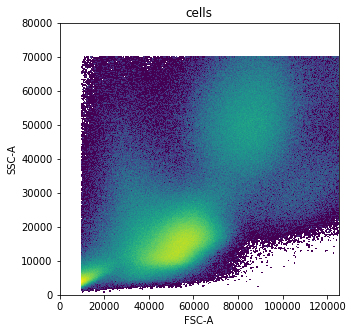

In [9]:
_ = t_template.plot_population('cells', x='FSC-A', y='SSC-A', xlim=(0,125000), ylim=(0,80000))

In [10]:
kwargs=dict(target=(50000,15000), k=4)
t_template.create_gate(gate_name='lymphocyte_gate', children=['lymphocytes'], parent='cells', x='FSC-A',
                      y='SSC-A', func='mm_gate', func_args=kwargs, gate_type='geom')

True

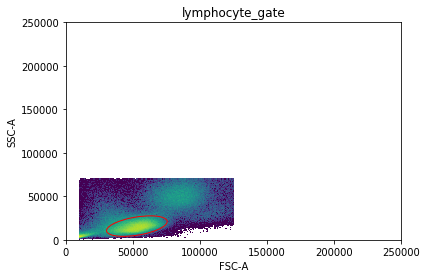

In [11]:
t_template.apply('lymphocyte_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0a5c2b7828>)

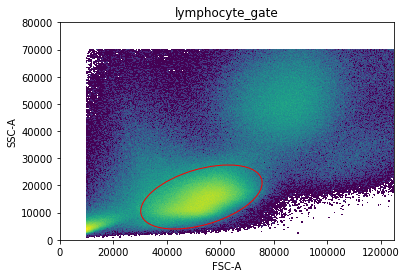

In [12]:
t_template.plot_gate('lymphocyte_gate', xlim=(0,125000), ylim=(0,80000))

<h3>Singlet gate</h3>

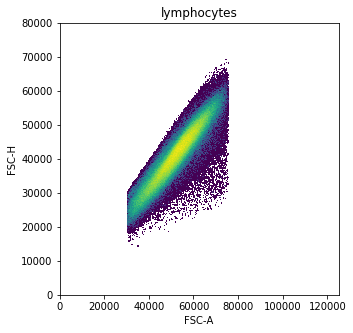

In [13]:
_ = t_template.plot_population('lymphocytes', x='FSC-A', y='FSC-H', xlim=(0,125000), ylim=(0,80000))

In [14]:
kwargs=dict(target=(60000,40000), k=2, conf=0.99)
t_template.create_gate(gate_name='singlet_gate', children=['singlets'], parent='lymphocytes', x='FSC-A',
                      y='FSC-H', func='mm_gate', func_args=kwargs, gate_type='geom')

True

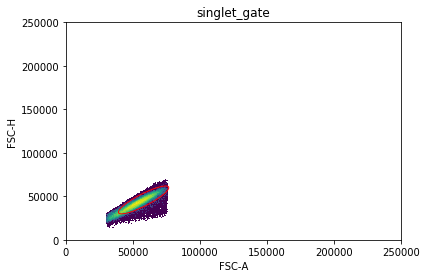

In [15]:
t_template.apply('singlet_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0a0ea9b668>)

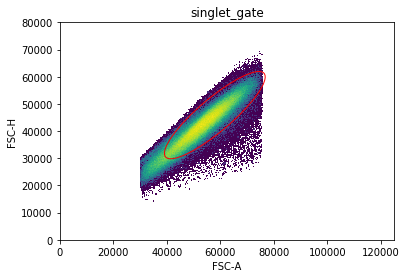

In [16]:
t_template.plot_gate('singlet_gate', xlim=(0,125000), ylim=(0,80000))

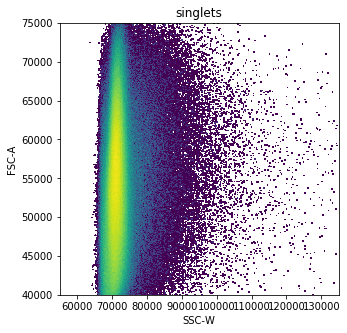

In [17]:
_ = t_template.plot_population('singlets', x='SSC-W', y='FSC-A', xlim=(55000,135000), ylim=(40000,75000))

In [18]:
kwargs=dict(q=0.95)
t_template.create_gate(gate_name='singlet_gate_2', children=['singlets2'], parent='singlets', x='SSC-W',
                       func='quantile_gate', func_args=kwargs, gate_type='geom')

True

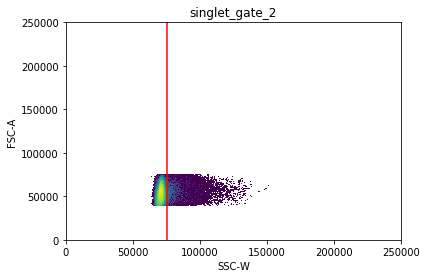

In [19]:
t_template.apply('singlet_gate_2')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0a356899e8>)

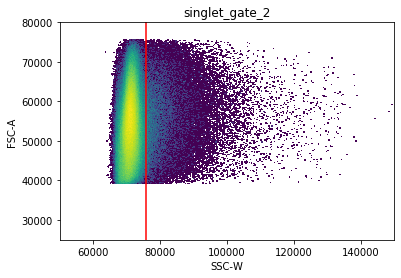

In [20]:
t_template.plot_gate('singlet_gate_2', xlim=(50000,150000), ylim=(25000, 80000))

<h3>Live/Dead Gate</h3>

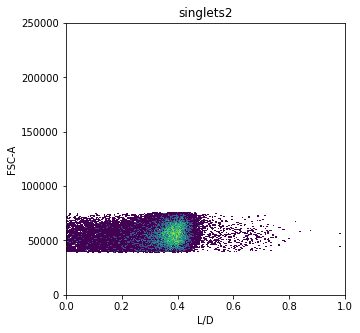

In [21]:
_ = t_template.plot_population('singlets2', x='L/D', y='FSC-A')

In [22]:
kwargs=dict(q=0.99, bool_gate=True, kde_bw=0.1, kde_sample_frac=0.5, ignore_double_pos=True, 
            peak_threshold=0.05)
t_template.create_gate(gate_name='livedead_gate', children=['live'], parent='singlets2', x='L/D',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

True

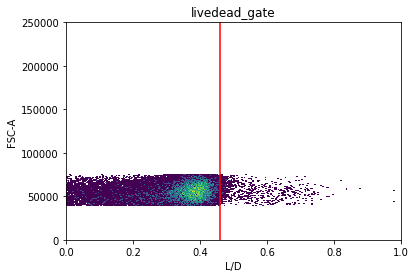

In [23]:
t_template.apply('livedead_gate')

<h3>T Cells (CD3+)</h3>

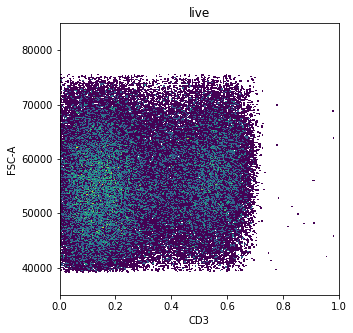

In [24]:
_ = t_template.plot_population('live', x='CD3', y='FSC-A', ylim=(35000,85000))

In [25]:
kwargs=dict(q=0.95, kde_bw=0.1, kde_sample_frac=1, ignore_double_pos=True, 
            peak_threshold=0.05)
t_template.create_gate(gate_name='cd3_gate', children=['cd3+'], parent='live', x='CD3',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

True

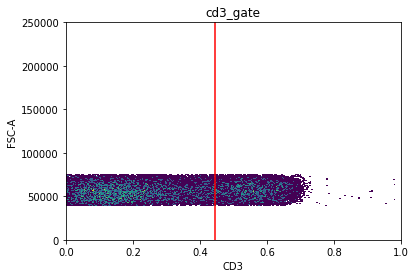

In [26]:
t_template.apply('cd3_gate')

<h3>Gamma Delta T cells</h3>

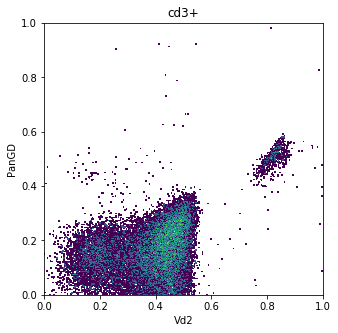

In [27]:
_ = t_template.plot_population('cd3+', x='Vd2', y='PanGD')

In [28]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, expected_populations=[{'id': 'gdt', 'target': (0.9, 0.6)},
                                                                   {'id': 'vd2-', 'target': (0.2, 0.6)},
                                                                   {'id': 'non_gdt', 'target': (0.3, 0.1)}],
            core_only=False)
t_template.create_gate(gate_name='gdt_gate', children=['gdt', 'vd2-', 'non_gdt'], parent='cd3+', x='Vd2',
                       y='PanGD', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

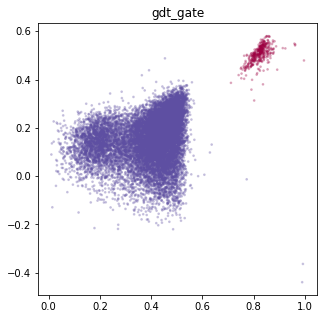

In [29]:
t_template.apply('gdt_gate')

<h3>MAITs</h3>

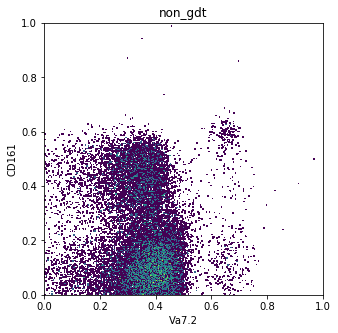

In [30]:
_ = t_template.plot_population('non_gdt', x='Va7.2', y='CD161')

In [31]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, expected_populations=[{'id': 'mait', 'target': (0.8, 0.6)},
                                                                   {'id': 'classic_tcells', 'target': (0.3, 0.3)}],
            core_only=False, nn=10, sample=0.3)
t_template.create_gate(gate_name='mait_gate', children=['mait', 'classic_tcells'], parent='non_gdt', x='Va7.2',
                       y='CD161', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

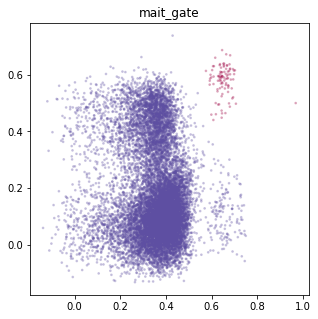

In [32]:
t_template.apply('mait_gate')

<h3>Classic T cells</h3>

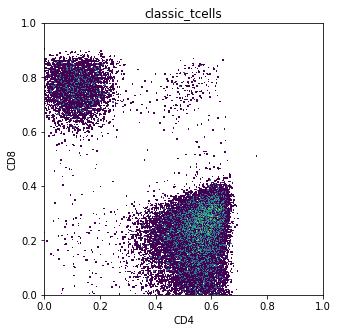

In [33]:
_ = t_template.plot_population('classic_tcells', x='CD4', y='CD8')

In [34]:
kwargs=dict(min_pop_size=100, distance_nn=0.05, expected_populations=[{'id': 'cd4', 'target': (0.8, 0.3)},
                                                                      {'id': 'cd8', 'target': (0.1, 0.8)}],
            core_only=False, nn=10, sample=0.3)
t_template.create_gate(gate_name='cd4cd8_gate', children=['cd4', 'cd8'], parent='classic_tcells', 
                       x='CD4',y='CD8', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

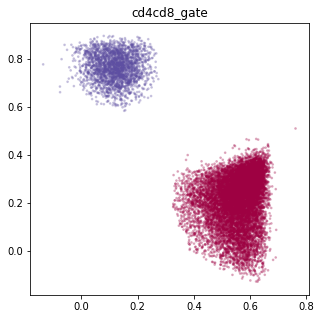

In [35]:
t_template.apply('cd4cd8_gate')

In [37]:
t_template.populations.keys()

dict_keys(['root', 'cells', 'lymphocytes', 'singlets', 'singlets2', 'live', 'cd3+', 'gdt', 'vd2-', 'non_gdt', 'mait', 'classic_tcells', 'cd4', 'cd8'])

In [42]:
data = t_template.data.copy()
data.to_csv('experiment_data/data/pd318_10.csv')

In [45]:
import pickle
with open('experiment_data/data/pd318_10_pops.pickle', 'wb') as f:
    pickle.dump(t_template.populations, f)

<h2>Comparing supervised machine learning algorithms for predicting FMO labels</h2>

For each of the populations above I'm going to rank a some machine learning algorithms in terms of predictive accuracy, training time, and predictive time. For each algorithm I will use grid search CV optimisation to find the optimal parameters for each population. 

The following models will be considered:
* XGBoost
* Support Vector Machine
* Logistic Regression
* K nearest neighbours

The above have been considered because they have reported fast training times and also allow for the attributing class weights during learning; this is true for all except KNN, for KNN I will use oversampling.

In [92]:
from xgboost.sklearn import XGBClassifier as XGB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np
import pickle

In [53]:
data = pd.read_csv('experiment_data/data/pd318_10.csv')
with open('experiment_data/data/pd318_10_pops.pickle', 'rb') as f:
    populations = pickle.load(f)

<h3>Calculate optimal parameters</h3>

In [59]:
features = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W',
            'CXCR3', 'CD161', 'CD3', 'CCR7', 'L/D', 'Va7.2', 'CD8', 'Vd2', 'CD45RA',
            'PanGD', 'CD4', 'CD27']

In [94]:
def grid_search(model, params, calc_weight_scale=None):
    param_tune_results = dict()
    print('=============================================')
    for population_name, pop_data in populations.items():
        if population_name == 'root':
            continue
        print(f'Calculating best parameters for {population_name}')

        #Prep data
        index = pop_data['index']
        parent = pop_data['parent']
        parent_index = populations[parent]['index']
        parent_data = data[data.index.isin(parent_index)]
        pos = parent_data[parent_data.index.isin(index)].index.values
        X = parent_data.copy()
        X['pos'] = 0
        for i in pos:
            X.set_value(i, 'pos', 1)
        Y = X['pos'].values
        X = X[features]
        if calc_weight_scale:
            params[calc_weight_scale].append((X.shape[0]/sum(Y)))
        gs = GridSearchCV(model, params, cv=5, n_jobs=-1)
        gs.fit(X, Y)
        param_tune_results[population_name] = gs.cv_results_
    print('=============================================')
    return param_tune_results

In [95]:
xgb = XGB()
params = dict(eta=[0.01, 0.1, 0.15, 0.2, 0.3], gamma=[0, 3, 6, 9], min_child_weight=[1,5,10,15],
                 subsample=[0.5, 1], scale_pos_weight = [1],
                 predictor=['gpu_predictor'], max_depth=[2,4,6,8])
xgb_results = grid_search(xgb, params, calc_weight_scale='scale_pos_weight')

Calculating best parameters for cells


exception calling callback for <Future at 0x7f0a4471abe0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/ross/immunova/env/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/ross/immunova/env/lib/python3.6/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/ross/immunova/env/lib/python3.6/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/ross/immunova/env/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/ross/immunova/env/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/ross/immunova/env/lib/python3.6/site-packages/joblib/_parallel_backends.py", line 510, in apply_async

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6)}

In [ ]:
svm = SVC(class_weight='balanced', cache_size=1000)
params = dict(kernel=['linear', 'poly', 'rbf', 'sigmoid'], gamma=['auto', 'scale'])
svm_results = grid_search(svm, params)

In [ ]:
lr = LogisticRegression()
params = dict(penalty=['l2', 'elasticnet'], class_weight=['balanced', None], random_state=[42])
xgb_results = grid_search(xgb, params)